### Random forest model training

In [107]:
import pandas as pd
import numpy as np
import seaborn as sea
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [108]:
#import the csv file needed to train the model
df=pd.read_csv('cleaned_busyness_data.csv')
df.head(10)

,remote_unit_id,time_stamp,entries,exits,surrounding_area_busyness,station_busyness,hour,day,month,temperature,weather,rain_fall,snow_fall
0,1,1546300800,0,0,0,12,0,Tuesday,January,3.42,Rain,3.06,4.40
1,1,1546315200,102,104,0,18,4,Tuesday,January,5.89,Rain,3.77,2.21
2,1,1546329600,96,51,0,16,8,Tuesday,January,11.18,Mist,0.00,0.12
3,1,1546344000,260,476,77,42,12,Tuesday,January,13.55,Rain,0.25,0.06
4,1,1546358400,540,496,0,58,16,Tuesday,January,11.68,Rain,0.50,0.25
5,1,1546372800,602,250,0,48,20,Tuesday,January,3.70,Clouds,0.00,0.05
6,1,1546387200,159,147,0,22,0,Wednesday,January,2.05,Clouds,0.00,0.00
7,1,1546401600,48,38,0,14,4,Wednesday,January,-0.06,Clouds,0.00,0.00
8,1,1546416000,516,434,0,54,8,Wednesday,January,-2.08,Clear,0.00,0.00
9,1,1546430400,842,1351,99,96,12,Wednesday,January,-1.88,Clear,0.00,0.00


In [109]:
#convert monthand day to numerical columns
df['month']=df['month'].map({'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,
                                'July':7,'August':8,'September':9,'October':10,'November':11,'December':12})
df['day']=df['day'].map({'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7})


In [110]:
#convert weather to categorical columns
df['weather']=df['weather'].astype('category')

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297835 entries, 0 to 297834
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   remote_unit_id             297835 non-null  int64   
 1   time_stamp                 297835 non-null  int64   
 2   entries                    297835 non-null  int64   
 3   exits                      297835 non-null  int64   
 4   surrounding_area_busyness  297835 non-null  int64   
 5   station_busyness           297835 non-null  int64   
 6   hour                       297835 non-null  int64   
 7   day                        297835 non-null  int64   
 8   month                      297835 non-null  int64   
 9   temperature                297835 non-null  float64 
 10  weather                    297835 non-null  category
 11  rain_fall                  297835 non-null  float64 
 12  snow_fall                  297835 non-null  float64 
dtypes: category(1)

/tmp/ipykernel_19014/2506163149.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mat=df.corr()


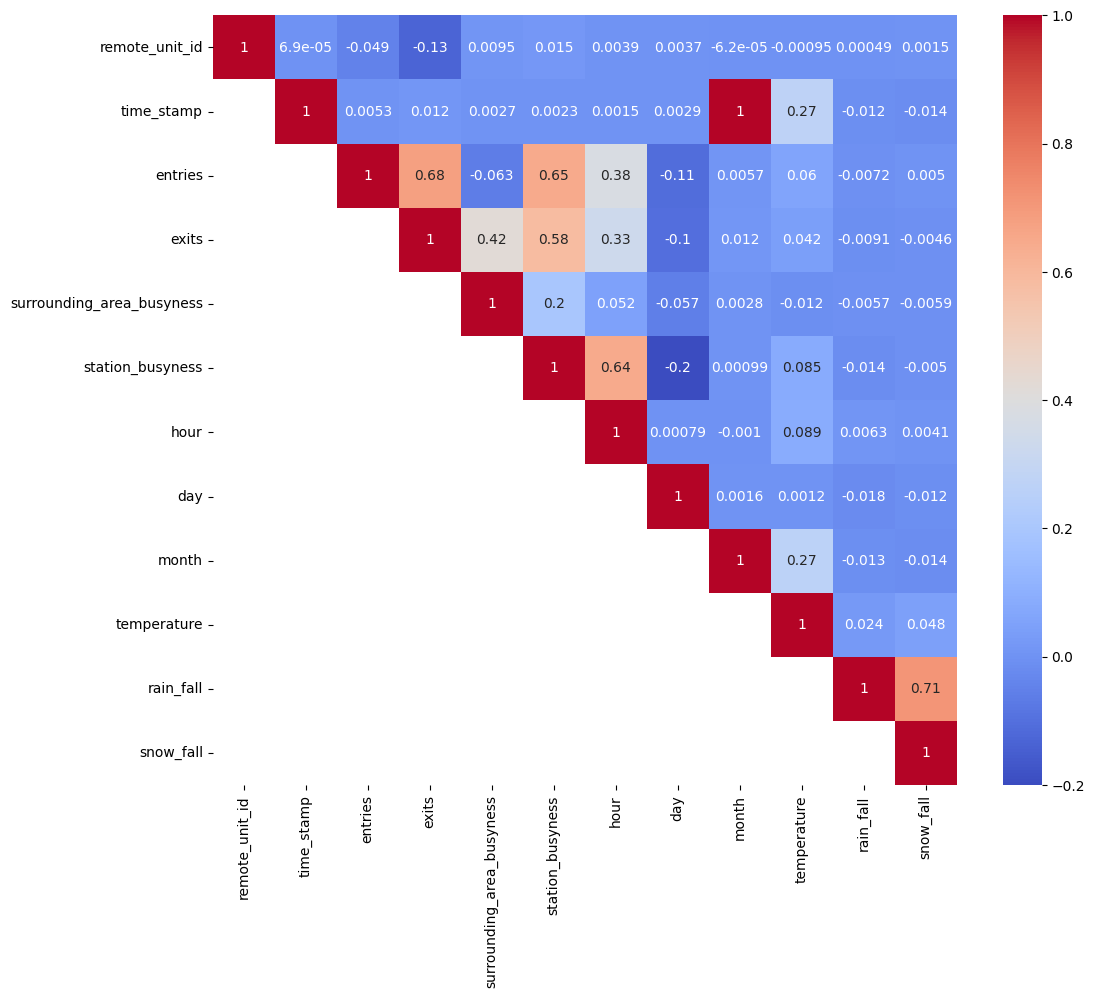

In [112]:
mat=df.corr()

# create a mask to drop the upper triangle
mask = np.triu(np.ones_like(mat, dtype=bool))

# apply the mask to the correlation matrix
mat = mat.where(mask)

fig, ax = plt.subplots(figsize=(12, 10))

sea.heatmap(mat, annot=True, cmap='coolwarm', ax=ax)

# show the plot
plt.show()

In [113]:
df.columns

Index(['remote_unit_id', 'time_stamp', 'entries', 'exits',
       'surrounding_area_busyness', 'station_busyness', 'hour', 'day', 'month',
       'temperature', 'weather', 'rain_fall', 'snow_fall'],
      dtype='object')

## One hot encoding for categorical features


In [114]:
one_hot = pd.get_dummies(df['weather'])
df = pd.concat([df, one_hot], axis = 1)

In [115]:
df.head()

,remote_unit_id,time_stamp,entries,exits,surrounding_area_busyness,station_busyness,hour,day,month,temperature,...,Clear,Clouds,Drizzle,Fog,Haze,Mist,Rain,Smoke,Snow,Thunderstorm
0,1,1546300800,0,0,0,12,0,2,1,3.42,...,0,0,0,0,0,0,1,0,0,0
1,1,1546315200,102,104,0,18,4,2,1,5.89,...,0,0,0,0,0,0,1,0,0,0
2,1,1546329600,96,51,0,16,8,2,1,11.18,...,0,0,0,0,0,1,0,0,0,0
3,1,1546344000,260,476,77,42,12,2,1,13.55,...,0,0,0,0,0,0,1,0,0,0
4,1,1546358400,540,496,0,58,16,2,1,11.68,...,0,0,0,0,0,0,1,0,0,0


## Functions to train the models

In [116]:

def divide_data_surrounding_area_busy(station_number, dataframe):
    df_inner = dataframe[dataframe['remote_unit_id'] == station_number].copy()
    #print(df_main)
    y=df_inner['surrounding_area_busyness'].values
    #drop these values for query search
    df_inner=df_inner.drop(columns=['surrounding_area_busyness','remote_unit_id'])
    X = df_inner.values
    
    # Split the data into train and test sets- alter this later to be tested on last 3 months 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    #print(X_train, y_test)

    return df_inner, X_train, y_train, X_test, y_test


def divide_data_station_busy(station_number, dataframe):
    df_inner = dataframe[dataframe['remote_unit_id'] == station_number].copy()
    #print(df_main)
    y=df_inner['station_busyness'].values
    #drop these values for query search
    df_inner=df_inner.drop(columns=['station_busyness','remote_unit_id'])
    X = df_inner.values
    
    # Split the data into train and test sets- alter this later to be tested on last 3 months 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    #print(X_train, y_test)

    return df_inner, X_train, y_train, X_test, y_test

train_mae_list = []
test_mae_list = []
train_rmse_list = []
test_rmse_list = []
train_score_list = []
test_score_list = []

def forest_training_model(train_x, train_y, test_x, test_y):
    #print(train_x)
    forest = RandomForestClassifier(n_estimators=50,max_depth=10)
    forest=forest.fit(train_x, train_y)

    ##mae and rmse
    #print(f"train MAE : {mean_absolute_error(train_y, forest.predict(train_x))}")
    train_mae_list.append(mean_absolute_error(train_y, forest.predict(train_x)))
    #print(f"test MAE : {mean_absolute_error(test_y, forest.predict(test_x))}")
    test_mae_list.append(mean_absolute_error(test_y, forest.predict(test_x)))
    #print(f"train RMSE : {np.sqrt(mean_squared_error(train_y, forest.predict(train_x)))}")
    train_rmse_list.append(np.sqrt(mean_squared_error(train_y, forest.predict(train_x))))
    #print(f"test RMSE : {np.sqrt(mean_squared_error(test_y, forest.predict(test_x)))}")
    test_rmse_list.append(np.sqrt(mean_squared_error(test_y, forest.predict(test_x))))
    #print(f"train score : {forest.score(train_x, train_y)}")##gives the R2 score
    train_score_list.append(forest.score(train_x, train_y))
    #print(f"test score : {forest.score(test_x, test_y)}")
    test_score_list.append(forest.score(test_x, test_y))
    return forest
    

## Function to save the models

In [117]:
def save_model_station_busy(model, station_number):
    filename = f'/home/cian/Documents/GitHub/NYSeeNow/NYSeeNow-ML/SubwayData/station_busy/s_busy_model_{station_number}.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(model, file, pickle.HIGHEST_PROTOCOL)

def save_model_area_busy(model, station_number):
    filename = f'/home/cian/Documents/GitHub/NYSeeNow/NYSeeNow-ML/SubwayData/area_busy/a_busy_model_{station_number}.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(model, file, pickle.HIGHEST_PROTOCOL)

## Execute the models

In [118]:
df.drop(columns=['weather'], inplace=True)
df_pickle=df.copy()

### Get station numbers

In [119]:
df_static = pd.read_csv('cleaned_station_data.csv')
check=df_static["remote_unit_id"]
order=check.tolist()
#now order the stations
order.sort()
order
#len(order)

[1,
 2,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 20,
 21,
 22,
 23,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 54,
 72,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 101,
 102,
 105,
 111,
 113,
 116,
 118,
 125,
 126,
 131,
 132,
 138,
 139,
 142,
 143,
 144,
 159,
 160,
 163,
 164,
 166,
 167,
 168,
 169,
 170,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 203,
 206,
 207,
 227,
 240,
 248,
 251,
 257,
 259,
 260,
 272,
 273,
 274,
 280,
 281,
 282,
 290,
 293,
 296,
 300,
 302,
 304,
 305,
 311,
 314,
 315,
 319,
 320,
 321,
 322,
 323,
 324,
 330,
 331,
 332,
 333,
 334,
 343,
 344,
 345,
 452,
 453,
 461,
 462,
 463,
 570,
 571,
 572]

In [120]:
for station_number in df['remote_unit_id'].unique():
    df_station, x_train, y_train, x_test, y_test = divide_data_surrounding_area_busy(station_number, df_pickle)
    #print(df_station)
    model = forest_training_model(x_train, y_train, x_test, y_test)
    save_model_area_busy(model, station_number)

#print average scores
print(f"Average train MAE : {np.mean(train_mae_list)}")
print(f"Average test MAE : {np.mean(test_mae_list)}")
print(f"Average train RMSE : {np.mean(train_rmse_list)}")
print(f"Average test RMSE : {np.mean(test_rmse_list)}")
print(f"train score : {np.mean(train_score_list)}")
print(f"test score : {np.mean(test_score_list)}")

Average train MAE : 2.4580476284854123
Average test MAE : 8.978962886638863
Average train RMSE : 10.324250541359248
Average test RMSE : 21.828714852972233
train score : 0.9360234722296871
test score : 0.6867828839195701


In [121]:
for station_number in df['remote_unit_id'].unique():
    df_station, x_train, y_train, x_test, y_test = divide_data_station_busy(station_number, df_pickle)
    #print(df_station)
    model = forest_training_model(x_train, y_train, x_test, y_test)
    save_model_station_busy(model, station_number)

#print average scores
print(f"Average train MAE : {np.mean(train_mae_list)}")
print(f"Average test MAE : {np.mean(test_mae_list)}")
print(f"Average train RMSE : {np.mean(train_rmse_list)}")
print(f"Average test RMSE : {np.mean(test_rmse_list)}")
print(f"train score : {np.mean(train_score_list)}")
print(f"test score : {np.mean(test_score_list)}")

Average train MAE : 1.5216255741204991
Average test MAE : 6.601368963832731
Average train RMSE : 6.484700379672388
Average test RMSE : 14.487839596816428
train score : 0.9175856241948317
test score : 0.43144674928548316


In [122]:
# Lets explore the data
# filter the DataFrame to only include rows where 'Monday' equals 1
df_mondays = df[df['day'] == 1]
#pick one station
df_mondays_1 = df_mondays[df_mondays['remote_unit_id'] == 1]
df_mondays_1.head()

,remote_unit_id,time_stamp,entries,exits,surrounding_area_busyness,station_busyness,hour,day,month,temperature,...,Clear,Clouds,Drizzle,Fog,Haze,Mist,Rain,Smoke,Snow,Thunderstorm
36,1,1546819200,229,126,0,24,0,1,1,-4.20,...,0,1,0,0,0,0,0,0,0,0
37,1,1546833600,62,39,0,15,4,1,1,-7.31,...,1,0,0,0,0,0,0,0,0,0
38,1,1546848000,537,218,0,43,8,1,1,-8.25,...,1,0,0,0,0,0,0,0,0,0
39,1,1546862400,794,1822,100,99,12,1,1,-9.32,...,1,0,0,0,0,0,0,0,0,0
40,1,1546876800,630,370,0,56,16,1,1,-7.56,...,1,0,0,0,0,0,0,0,0,0


### Make some plots to better understand the busyness for each station

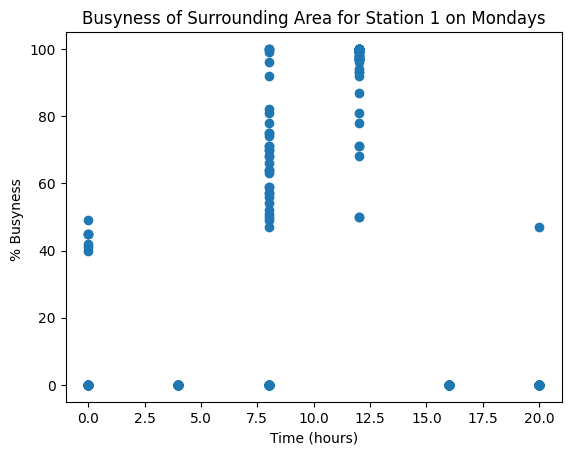

In [123]:
# create scatter plot using the filtered DataFrame
plt.scatter(df_mondays_1['hour'], df_mondays_1['surrounding_area_busyness'])
plt.title("Busyness of Surrounding Area for Station 1 on Mondays")
plt.ylabel("% Busyness ")
plt.xlabel("Time (hours)")
plt.show()
